# Problem Statement
###### The problem is to develop a machine learing model to predict Ocular Diseases via diagnostic parameters and images 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [2]:
CSV = pd.read_csv("full_df.csv")
eye_df = pd.DataFrame(CSV)
eye_df.head(5)

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_right.jpg,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
print(list(eye_df.columns))

['ID', 'Patient Age', 'Patient Sex', 'Fundus', 'Diagnostic Keywords', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename']


# Missing Value Check

In [4]:
# Displaying information
print(eye_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   3194 non-null   int64 
 1   Patient Age          3194 non-null   int64 
 2   Patient Sex          3194 non-null   object
 3   Fundus               3194 non-null   object
 4   Diagnostic Keywords  3194 non-null   object
 5   N                    3194 non-null   int64 
 6   D                    3194 non-null   int64 
 7   G                    3194 non-null   int64 
 8   C                    3194 non-null   int64 
 9   A                    3194 non-null   int64 
 10  H                    3194 non-null   int64 
 11  M                    3194 non-null   int64 
 12  O                    3194 non-null   int64 
 13  filepath             3194 non-null   object
 14  labels               3194 non-null   object
 15  target               3194 non-null   object
 16  filena

In [5]:
# Checking for missing values and duplicates
print("Missing Values:\n", eye_df.isnull().sum())
print("Duplicate Entries: ", eye_df.duplicated().sum())

Missing Values:
 ID                     0
Patient Age            0
Patient Sex            0
Fundus                 0
Diagnostic Keywords    0
N                      0
D                      0
G                      0
C                      0
A                      0
H                      0
M                      0
O                      0
filepath               0
labels                 0
target                 0
filename               0
dtype: int64
Duplicate Entries:  0


# Data
 
The target variable is a binary label 'labels' indicating weather the presented case has any of the following:
Normal (N), Diabetes (D), Glaucoma (G), Cataract (C), Age related Macular Degeneration (A), Hypertension (H), Pathological Myopia (M), Other diseases/abnormalities (O)

The dataframe contains 3194 entries and 17 columns.  

overview of the columns:

- ID: Numerical ID of the entry.
- Patient Age: Age of the patient.
- Patient Sex: Gender of the patient.
- Fundus: The file name of the fundus image.
- Diagnostic Keywords: Keywords describing the diagnosis.
- N: Normal
- D: Diabetes
- G: Glaucoma
- C: Cataract
- A: Age related Macular Degeneration
- H: Hypertension
- M: Pathological Myopia
- O: Other diseases/abnormalities
- filepath: File path for the image df.
- labels: Labels in an array-like format.
- target: Target values in an array format.
- filename: Filename of the image.

It can be observed in the dataset that the Diagnosis consists of multiple cases among the distinguished categories but the label is mapped to a sigle value, thereby not accounting for the features present in the dataset:
From the above observation we can follow through with two approaches:
- Mapping Diagnostic Keywords with labels and identifing individual categories.
- Mapping all the features and taking into account all the cases.

We choose to follow the second approach to get the maximum input out of the dataset

# Data Transformation(Feature Engineering)

### Fixing File path

In [6]:
base_dir = '/Users/shivamthakur/Desktop/Python/Data Mining(Kaggle)/code/ODIR-5K/preprocessed_images/'
eye_df['filepath']= base_dir + eye_df['filename']+'/'
eye_df.head(5)

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_right.jpg,normal fundus,0,0,0,1,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [7]:
# Replace "non proliferative retinopathy" with "nonproliferativeretinopathy"
eye_df['Diagnostic Keywords'] = eye_df['Diagnostic Keywords'].str.replace('proliferative retinopathy', 'proliferativeretinopathy', regex=False)

# Splitting the 'Diagnostic Keywords' column by comma and expanding into separate rows
# Each keyword will have its own row with other columns duplicated
df_separated = eye_df.drop('Diagnostic Keywords', axis=1).join(
    eye_df['Diagnostic Keywords'].str.split('，', expand=True).stack().reset_index(level=1, drop=True).rename('Diagnostic Keyword')
)

# Removing leading and trailing spaces from the 'Diagnostic Keyword' column
df_separated['Diagnostic Keyword'] = df_separated['Diagnostic Keyword'].str.strip()

# Rearranging the columns to place the new 'Diagnostic Keyword' column after the 'Fundus' column
columns = list(df_separated.columns)
columns.remove('Diagnostic Keyword')
new_column_order = columns[:4] + ['Diagnostic Keyword'] + columns[4:]
df_reordered = df_separated[new_column_order]

df_reordered.head(36)



,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keyword,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_right.jpg,normal fundus,0,0,0,1,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_right.jpg,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
5,6,60,Male,6_right.jpg,epiretinal membrane,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_right.jpg,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_right.jpg,vitreous degeneration,0,0,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg


### Encoding

#### *Encoding Summary*(Gender)

- Male - 0
- Female - 1


In [8]:
# we can observe that there are no null values present in the dataset
# we can now convert the categorical data into numerical data

gender_mapping = {'Male': 0, 'Female': 1}
df_reordered['Patient Sex'] = df_reordered['Patient Sex'].map(gender_mapping)
df_reordered.head(36)

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keyword,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,1,0_right.jpg,normal fundus,0,0,0,1,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,0,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,0,2_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,0,4_right.jpg,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,1,5_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,0,6_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
5,6,60,0,6_right.jpg,epiretinal membrane,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,1,7_right.jpg,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,0,8_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,0,9_right.jpg,vitreous degeneration,0,0,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg


### *Mapping Summary*(Diagnostic Keyword)

- Normal Fundus                               - "normal"                     
- Cataract                                    - "cataract"                    
- Moderate/Mild non proliferative retinopathy(Diabetes) - "proliferativeretinopathy" 
- Glaucoma                                    - "glaucoma"                    
- Hypertensive                                - "hypertensive"               
- Myopia                                      - "myopia"                      
- Macular Degeneration                        - "maculardegeneration"         
- Drusen                                      - "drusen"                      
- Other                                       - "other"                       

In [9]:
# Function to categorize each row based on the first matching condition
def categorize_row(keyword):
    keyword = keyword.lower()
    if 'abnormal' in keyword:
        return 'O'                ###outlier case matching with normal
    elif 'normal' in keyword:
        return 'N'
    elif 'proliferativeretinopathy' in keyword:
        return 'D'
    elif 'glaucoma' in keyword:
        return 'G'
    elif 'cataract' in keyword:
        return 'C'
    elif 'macular degeneration' in keyword:
        return 'A'
    elif 'hypertensive' in keyword:
        return 'H'
    elif 'myopia' in keyword:
        return 'M'
    else:
        return 'O'

# Apply the categorization function to each row
df_reordered['Categorized Keyword'] = df_reordered['Diagnostic Keyword'].apply(categorize_row)

# Applying one-hot encoding
columns_for_encoding = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for col in columns_for_encoding:
    df_reordered[col] = (df_reordered['Categorized Keyword'] == col).astype(int)

# Dropping the 'Categorized Keyword' column as it is no longer needed
df_reordered = df_reordered.drop('Categorized Keyword', axis=1)

df_reordered.head(36)


,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keyword,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,1,0_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,0,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,0,2_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,0,4_right.jpg,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,1,5_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,0,6_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
5,6,60,0,6_right.jpg,epiretinal membrane,0,0,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,1,7_right.jpg,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,0,8_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,0,9_right.jpg,vitreous degeneration,0,0,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg


### *Mapping*(Labels)

- [N]
- [D]
- [G]
- [C]
- [A]
- [H]
- [M] 
- [O] 

In [10]:
# Function to replace labels based on the presence of 1s in the columns N, D, G, C, A, H, M, and O
def replace_labels(row):
    labels = []
    for col in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
        if row[col] == 1:
            labels.append(col)
    return labels

# Applying the function to each row
df_reordered['labels'] = df_reordered.apply(replace_labels, axis=1)

df_reordered.head(40)

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keyword,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,1,0_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[N],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,0,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[N],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,0,2_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,0,4_right.jpg,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,1,5_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,0,6_right.jpg,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
5,6,60,0,6_right.jpg,epiretinal membrane,0,0,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,[O],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,1,7_right.jpg,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,0,8_right.jpg,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[N],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,0,9_right.jpg,vitreous degeneration,0,0,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,[O],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg


In [11]:
df_transformed = df_reordered.drop(columns=['target','Fundus'],axis=1)

# Descriptive Stats.

In [12]:
# Descriptive statistics for numerical columns
print("Descriptive Statistics:\n", df_transformed.describe())

Descriptive Statistics:
                 ID  Patient Age  Patient Sex            N            D  \
count  3480.000000  3480.000000  3480.000000  3480.000000  3480.000000   
mean   2185.803736    58.101724     0.468103     0.403448     0.241667   
std    1419.730922    11.718701     0.499053     0.490660     0.428155   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%     848.750000    52.000000     0.000000     0.000000     0.000000   
50%    2234.000000    59.000000     0.000000     0.000000     0.000000   
75%    3234.250000    66.000000     1.000000     1.000000     0.000000   
max    4784.000000    91.000000     1.000000     1.000000     1.000000   

                 G            C            A            H            M  \
count  3480.000000  3480.000000  3480.000000  3480.000000  3480.000000   
mean      0.041667     0.042816     0.041379     0.027874     0.038218   
std       0.199855     0.202471     0.199195     0.164634     0.191751   
min       0.

- ID: Ranges from 0 to 4784, but there are only 3194 entries, indicating some IDs are missing.


# Exploratory Data Analysis

### Gender

- Male: 0
- Female: 1

In [13]:
# Distribution of categorical columns
print("Patient Sex Distribution:\n", df_transformed['Patient Sex'].value_counts())


Patient Sex Distribution:
 Patient Sex
0    1851
1    1629
Name: count, dtype: int64


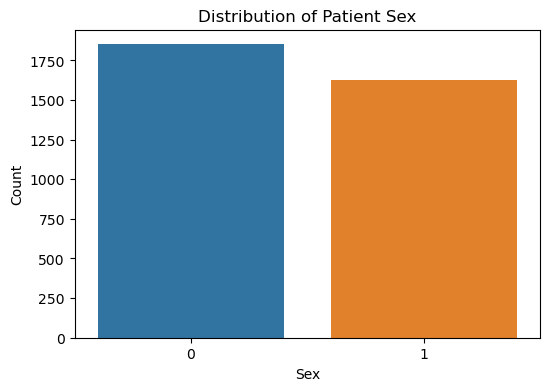

In [14]:
# Count plot for Patient Sex
plt.figure(figsize=(6, 4))
sns.countplot(x="Patient Sex", data=df_transformed)
plt.title('Distribution of Patient Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

### Gender vs Age

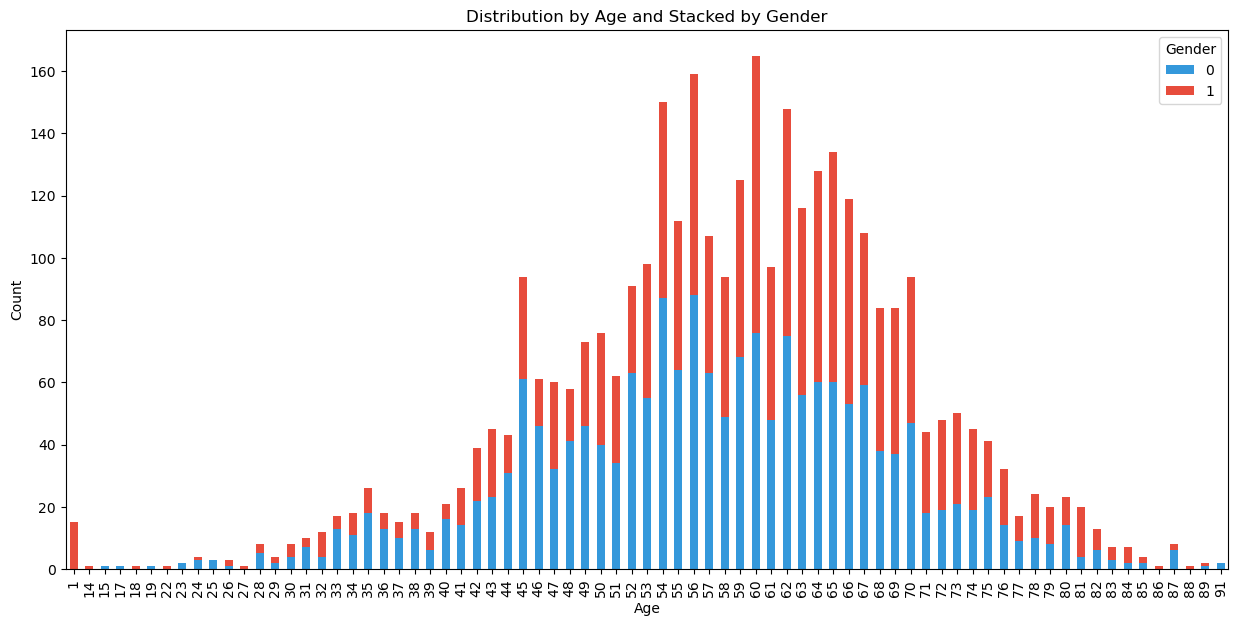

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Grouping the df by age and counting the number of males and females in each group
age_gender_distribution = df_transformed.groupby(['Patient Age', 'Patient Sex']).size().unstack(fill_value=0)

colors = ["#3498db", "#e74c3c"] 

# Creating the stacked bar plot
age_gender_distribution.plot(kind='bar', stacked=True, color=colors, figsize=(15, 7))
plt.title('Distribution by Age and Stacked by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()


### Labels

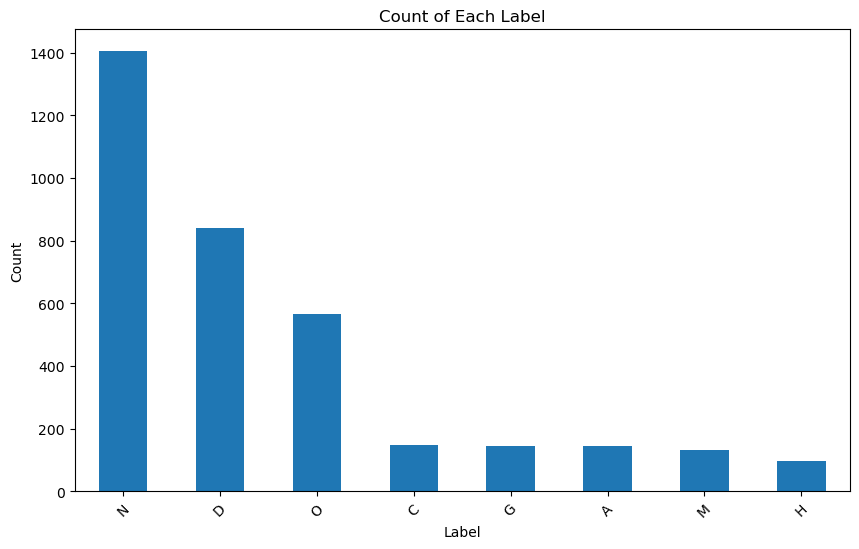

In [16]:

all_labels = [label for sublist in df_transformed['labels'] for label in sublist]

# Convert to a DataFrame for plotting
labels_df = pd.DataFrame(all_labels, columns=['Label'])

# Plot a count plot
plt.figure(figsize=(10, 6))
labels_df['Label'].value_counts().plot(kind='bar')
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [17]:
a= df_transformed['labels'].value_counts()
a

labels
[N]    1404
[D]     841
[O]     567
[C]     149
[G]     145
[A]     144
[M]     133
[H]      97
Name: count, dtype: int64

### Labels vs Age

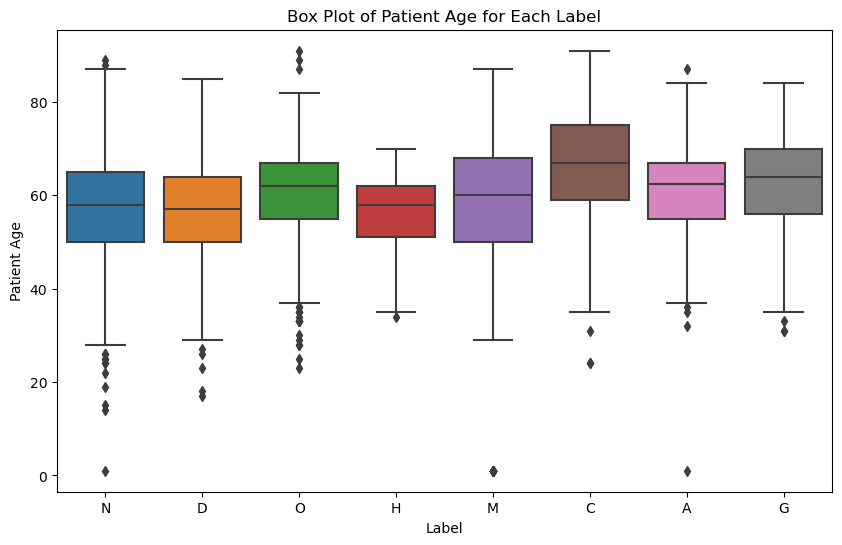

In [18]:

df_exploded = df_transformed.explode('labels')

# Plotting the box plot again
plt.figure(figsize=(10, 6))
sns.boxplot(x='labels', y='Patient Age', data=df_exploded)
plt.title('Box Plot of Patient Age for Each Label')
plt.xlabel('Label')
plt.ylabel('Patient Age')
plt.show()


# Correlation Matrix

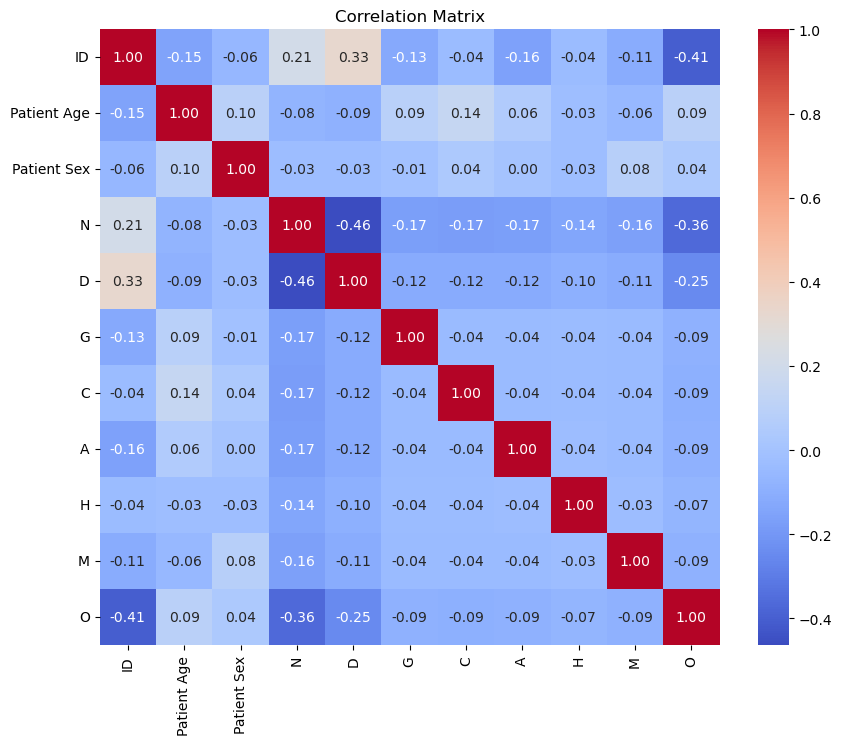

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant columns for the correlation matrix
columns_of_interest = ['ID', 'Patient Age', 'Patient Sex', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
df_subset = df_transformed[columns_of_interest]

# Calculating the correlation matrix
corr_matrix = df_subset.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


From the above we can observe

- inverse correlation between N and D: -0.46
- inverse correlation between N and D: -0.36

we know patient ID is an independent variable and a unique identifier for the patient

In [20]:
df_transformed

,ID,Patient Age,Patient Sex,Diagnostic Keyword,N,D,G,C,A,H,M,O,filepath,labels,filename
0,0,69,1,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[N],0_right.jpg
1,1,57,0,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[N],1_right.jpg
2,2,42,0,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],2_right.jpg
3,4,53,0,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],4_right.jpg
4,5,50,1,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,4688,42,0,moderate non proliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],4688_right.jpg
3191,4689,54,0,normal fundus,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[N],4689_right.jpg
3192,4690,57,0,mild nonproliferativeretinopathy,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[D],4690_right.jpg
3193,4784,58,0,hypertensive retinopathy,0,0,0,0,0,1,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,[H],4784_right.jpg


# Encoding

### Diagnostic Keywords Encoding

In [21]:
#df_transformed['Diagnostic Keyword'] = df_transformed['Diagnostic Keyword'].str.replace(' ', '')
df_transformed['Diagnostic Keyword'].unique()


array(['normal fundus', 'moderate non proliferativeretinopathy',
       'mild nonproliferativeretinopathy', 'epiretinal membrane',
       'vitreous degeneration', 'hypertensive retinopathy',
       'pathological myopia', 'macular epiretinal membrane',
       'myelinated nerve fibers', 'drusen', 'cataract',
       'abnormal pigment', 'dry age-related macular degeneration',
       'glaucoma', 'laser spot', 'epiretinal membrane over the macula',
       'diabetic retinopathy', 'wet age-related macular degeneration',
       'atrophic change', 'retinitis pigmentosa', 'white vessel',
       'proliferative diabetic retinopathy', 'refractive media opacity',
       'severe nonproliferativeretinopathy', 'lens dust',
       'spotted membranous change', 'maculopathy',
       'severe proliferative diabetic retinopathy', 'suspected glaucoma',
       'myopic maculopathy', 'branch retinal vein occlusion',
       'post laser photocoagulation', 'central retinal artery occlusion',
       'retinal pigment 

In [28]:
# enumerating the unique values of the text data in both the columns
unique_values = df_transformed['Diagnostic Keyword'].unique()
value_to_number = {value: number for number, value in enumerate(unique_values, start=1)}
df_transformed['Diagnostic Keyword'] = df_transformed['Diagnostic Keyword'].replace(value_to_number)
df_transformed.head()

,ID,Patient Age,Patient Sex,Diagnostic Keyword,N,D,G,C,A,H,M,O,filepath,filename,encoded_labels
0,0,69,1,1,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,0_right.jpg,6
1,1,57,0,1,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,1_right.jpg,6
2,2,42,0,2,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,2_right.jpg,2
3,4,53,0,3,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,4_right.jpg,2
4,5,50,1,2,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,5_right.jpg,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,4688,42,0,2,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,4688_right.jpg,2
3191,4689,54,0,1,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,4689_right.jpg,6
3192,4690,57,0,3,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,4690_right.jpg,2
3193,4784,58,0,6,0,0,0,0,0,1,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,4784_right.jpg,4


### Label Encoding [labels]



In [23]:
from sklearn.preprocessing import LabelEncoder

df_transformed['labels'] = df_transformed['labels'].apply(lambda x: ','.join(map(str, x)))

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the 'labels' column
df_transformed['encoded_labels'] = le.fit_transform(df_transformed['labels'])

df_transformed = df_transformed.drop(['labels'],axis=1)

df_transformed.to_csv("df_transformed.csv")

# Display the first few rows of the DataFrame
df_transformed.head(10)

,ID,Patient Age,Patient Sex,Diagnostic Keyword,N,D,G,C,A,H,M,O,filepath,filename,encoded_labels
0,0,69,1,1,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,0_right.jpg,6
1,1,57,0,1,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,1_right.jpg,6
2,2,42,0,2,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,2_right.jpg,2
3,4,53,0,3,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,4_right.jpg,2
4,5,50,1,2,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,5_right.jpg,2
5,6,60,0,2,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,6_right.jpg,2
5,6,60,0,4,0,0,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,6_right.jpg,7
6,7,60,1,3,0,1,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,7_right.jpg,2
7,8,59,0,1,1,0,0,0,0,0,0,0,/Users/shivamthakur/Desktop/Python/Data Mining...,8_right.jpg,6
8,9,54,0,5,0,0,0,0,0,0,0,1,/Users/shivamthakur/Desktop/Python/Data Mining...,9_right.jpg,7


## Re:Missing Value Check

In [24]:
# Checking for missing values and duplicates
print("Missing Values:\n", df_transformed.isnull().sum())
print("Duplicate Entries: ", df_transformed.duplicated().sum())

Missing Values:
 ID                    0
Patient Age           0
Patient Sex           0
Diagnostic Keyword    0
N                     0
D                     0
G                     0
C                     0
A                     0
H                     0
M                     0
O                     0
filepath              0
filename              0
encoded_labels        0
dtype: int64
Duplicate Entries:  3


- Accepting the above results and moving on with Modeling

# Modeling

In [25]:
y = df_transformed['encoded_labels']
X = df_transformed.drop(columns=['ID', 'filepath', 'filename', 'encoded_labels'])

In [26]:
X.head(5)

,Patient Age,Patient Sex,Diagnostic Keyword,N,D,G,C,A,H,M,O
0,69,1,1,1,0,0,0,0,0,0,0
1,57,0,1,1,0,0,0,0,0,0,0
2,42,0,2,0,1,0,0,0,0,0,0
3,53,0,3,0,1,0,0,0,0,0,0
4,50,1,2,0,1,0,0,0,0,0,0


In [27]:
y.head(5)

0    6
1    6
2    2
3    2
4    2
Name: encoded_labels, dtype: int64

### Model 1: Logistic Regression

In [32]:
# spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


LR_model1 = LogisticRegression()
LR_model1.fit(X_train, y_train)

y_pred = LR_model1.predict(X_train)
precision = precision_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
acc = accuracy_score(y_train, y_pred)

print('RESULTS FOR THE LOGISTIC REGRESSION - TRAINING DATA')
print('-----------------------------------------------------')
print(f'Logistic Regression Model - training dataset, the precision is: {precision}')
print(f'Logistic Regression Model - training dataset, the f1-score is: {f1}')
print(f'Logistic Regression Model - training dataset, the recall is: {recall}')
print(f'Logistic Regression Model - training dataset, the accuracy is: {acc}\n')

y_pred = LR_model1.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

print('RESULTS FOR THE LOGISTIC REGRESSION - TESTING DATA')
print('-----------------------------------------------------')
print(f'Logistic Regression Model - testing dataset, the precision is: {precision}')
print(f'Logistic Regression Model - testing dataset, the f1-score is: {f1}')
print(f'Logistic Regression Model - testing dataset, the recall is: {recall}')
print(f'Logistic Regression Model - testing dataset, the accuracy is: {acc}\n')

RESULTS FOR THE LOGISTIC REGRESSION - TRAINING DATA
-----------------------------------------------------
Logistic Regression Model - training dataset, the precision is: 0.9971542065287889
Logistic Regression Model - training dataset, the f1-score is: 0.9971336899694028
Logistic Regression Model - training dataset, the recall is: 0.9971264367816092
Logistic Regression Model - training dataset, the accuracy is: 0.9971264367816092

RESULTS FOR THE LOGISTIC REGRESSION - TESTING DATA
-----------------------------------------------------
Logistic Regression Model - testing dataset, the precision is: 0.9932754476127321
Logistic Regression Model - testing dataset, the f1-score is: 0.9928242602068302
Logistic Regression Model - testing dataset, the recall is: 0.992816091954023
Logistic Regression Model - testing dataset, the accuracy is: 0.992816091954023



/Users/shivamthakur/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model2: KNN

In [30]:
KNN_model2 = KNeighborsClassifier()
KNN_model2.fit(X_train, y_train)

y_pred = KNN_model2.predict(X_train)
precision = precision_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
acc = accuracy_score(y_train, y_pred)

print('RESULTS FOR THE KNN - TRAINING DATA')
print('-----------------------------------------------------')
print(f'KNN Model - training dataset, the precision is: {precision}')
print(f'KNN Model - training dataset, the f1-score is: {f1}')
print(f'KNN Model - training dataset, the recall is: {recall}')
print(f'KNN Model - training dataset, the accuracy is: {acc}\n')

y_pred = KNN_model2.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

print('RESULTS FOR THE KNN - TESTING DATA')
print('-----------------------------------------------------')
print(f'KNN Model - testing dataset, the precision is: {precision}')
print(f'KNN Model - testing dataset, the f1-score is: {f1}')
print(f'KNN Model - testing dataset, the recall is: {recall}')
print(f'KNN Model - testing dataset, the accuracy is: {acc}\n')

RESULTS FOR THE KNN - TRAINING DATA
-----------------------------------------------------
KNN Model - training dataset, the precision is: 0.9735030932814469
KNN Model - training dataset, the f1-score is: 0.9732929778406131
KNN Model - training dataset, the recall is: 0.9734195402298851
KNN Model - training dataset, the accuracy is: 0.9734195402298851

RESULTS FOR THE KNN - TESTING DATA
-----------------------------------------------------
KNN Model - testing dataset, the precision is: 0.9366352040343704
KNN Model - testing dataset, the f1-score is: 0.9356026624954971
KNN Model - testing dataset, the recall is: 0.9367816091954023
KNN Model - testing dataset, the accuracy is: 0.9367816091954023



<class 'pandas.core.frame.DataFrame'>
Index: 3480 entries, 0 to 3193
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  3480 non-null   int64 
 1   Patient Age         3480 non-null   int64 
 2   Patient Sex         3480 non-null   int64 
 3   Diagnostic Keyword  3480 non-null   int64 
 4   N                   3480 non-null   int64 
 5   D                   3480 non-null   int64 
 6   G                   3480 non-null   int64 
 7   C                   3480 non-null   int64 
 8   A                   3480 non-null   int64 
 9   H                   3480 non-null   int64 
 10  M                   3480 non-null   int64 
 11  O                   3480 non-null   int64 
 12  filepath            3480 non-null   object
 13  filename            3480 non-null   object
 14  encoded_labels      3480 non-null   int64 
dtypes: int64(13), object(2)
memory usage: 435.0+ KB
